# Time series, sequences and predictions
Sunspots 

## Importing Module

In [1]:
import os
import csv
import urllib

import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.8.2


## Problem

- Build and train a neural network model using the Sunspots.csv dataset.
- Use `MAE` as the metrics of your neural network model.
- We provided code for normalizing the data. Please do not change the code.
- Do not use lambda layers in your model.
- The dataset used in this problem is downloaded from kaggle.com/robervalt/sunspots
- Desired MAE < `0.15` on the normalized dataset.

### Preparing data

In [2]:
data_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/sunspots.csv'
name_file = 'sunspots.csv'

if os.path.isfile(name_file) == False:
  urllib.request.urlretrieve(data_url, name_file)
  print(f'{name_file} Downloaded')
else:
  print(f'{name_file} Already exist')

sunspots.csv Downloaded


#### Explore data

Load data using pandas

In [3]:
df = pd.read_csv(name_file, index_col=0)

In [4]:
df.columns = ['date', 'monthly_mean'] # rename column

print(f'Total Data : {df.shape[0]}')
print(f'Total Columns : {df.shape[1]}')

Total Data : 3265
Total Columns : 2


First 10 from data

In [5]:
df.head(10)

,date,monthly_mean
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5
9,1749-10-31,125.8


More information about data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          3265 non-null   object 
 1   monthly_mean  3265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 76.5+ KB


Visualize data

In [7]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

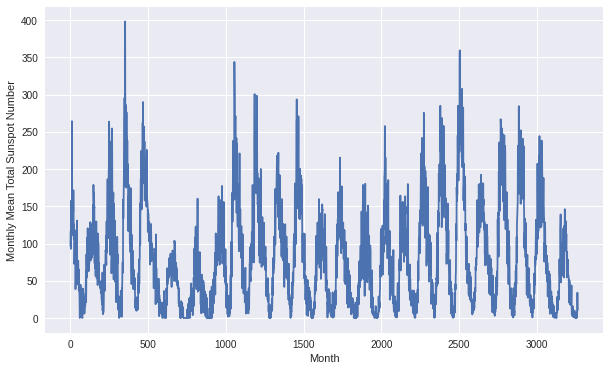

In [8]:
x = df.index
y = df['monthly_mean']

plot_series(x, y, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

### Preparing Model

Set Paramters

In [9]:
split_time = 3000
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

Prepare Feature and label (time from index series from montly_mean)

In [10]:
time = np.array(df.index)
series = np.array(df['monthly_mean'])

Normalization Data

In [11]:
min = np.min(series)
max = np.max(series)
series -= min
series /= max

Fixed Partition

In [12]:
# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

Windowing Data

In [13]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [14]:
train_set=windowed_dataset(x_train, window_size=window_size,
                           batch_size=batch_size, 
                           shuffle_buffer=shuffle_buffer_size)

#### Build Model

In [15]:
def build_model(WINDOW_SIZE, lr=1e-8):
  """
  Creates a model with learning rate schedule 
  for finding best learning rate
  
  Args:
      WINDOW_SIZE (int): the number of time steps to include in the feature
      lr (float): the number of learning rate optimizer

  Returns:
      model (tf.keras Model): the time, series model
  """

  # Define Params  
  adam = tf.keras.optimizers.Adam(learning_rate=lr) # Optimizer
  losses = tf.keras.losses.Huber()

  # Define Activation Function
  relu = tf.nn.relu

  # Define model sequential
  model = tf.keras.Sequential()

  # Define Convolutional 1D
  model.add(tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation=relu,
                      input_shape=[WINDOW_SIZE, 1]))
  
  # Define layers LSTM
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.LSTM(64))

  # Define Fully Connected layers
  model.add(tf.keras.layers.Dense(10, activation=relu))
  model.add(tf.keras.layers.Dense(10, activation=relu))
  model.add(tf.keras.layers.Dense(1))


  # Compile model
  model.compile(optimizer=adam, loss=losses, metrics=['mae'])

  # Check Summary Model
  model.summary()

  print('\nModel Succesfully Create')
  
  return model

#### Define Callbacks

In [16]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", 
                                                      monitor="mae",
                                                      save_best_only=True,
                                                      verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="mae", 
                                                  patience=20, 
                                                  mode ="min", 
                                                  verbose=2, 
                                                  restore_best_weights=True)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

### Train Model

#### Train model with learning rate schedule

In [17]:
model = build_model(window_size)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 60)            360       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            32000     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 66,155
Trainable params: 66,155
Non-traina

In [18]:
history_lr = model.fit(train_set ,epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 7s 39ms/step - loss: 0.0374 - mae: 0.2111 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 5s 52ms/step - loss: 0.0374 - mae: 0.2111 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 5s 53ms/step - loss: 0.0374 - mae: 0.2111 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 5s 54ms/step - loss: 0.0374 - mae: 0.2111 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 3s 29ms/step - loss: 0.0374 - mae: 0.2110 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 3s 29ms/step - loss: 0.0374 - mae: 0.2110 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 3s 29ms/step - loss: 0.0374 - mae: 0.2110 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 3s 29ms/step - loss: 0.0374 - mae: 0.2110 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 3s 29ms/step - loss: 0.0374 - mae: 0.2110 - lr: 2.5

Plot result of learning rate schedule

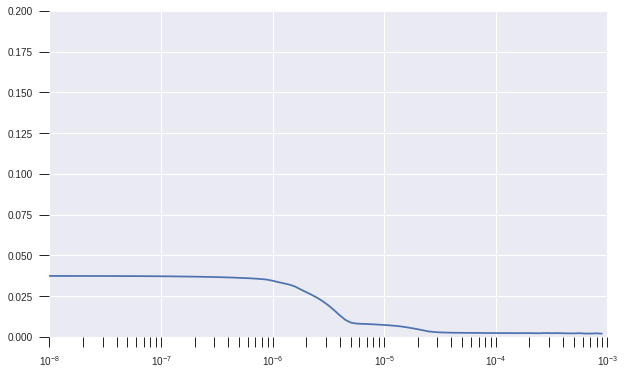

In [19]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history_lr.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, .2])
plt.show()

#### Train model with learning rate 8e-4

In [20]:
model = build_model(window_size, lr=8e-4)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 60)            360       
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            32000     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 66,155
Trainable params: 66,155
Non-trai

In [21]:
history = model.fit(train_set,
                    epochs=100, 
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
     93/Unknown - 6s 30ms/step - loss: 0.0094 - mae: 0.0912
Epoch 1: mae improved from inf to 0.09121, saving model to model.h5
93/93 [==============================] - 6s 30ms/step - loss: 0.0094 - mae: 0.0912
Epoch 2/100
93/93 [==============================] - ETA: 0s - loss: 0.0029 - mae: 0.0560
Epoch 2: mae improved from 0.09121 to 0.05604, saving model to model.h5
93/93 [==============================] - 3s 30ms/step - loss: 0.0029 - mae: 0.0560
Epoch 3/100
93/93 [==============================] - ETA: 0s - loss: 0.0027 - mae: 0.0536
Epoch 3: mae improved from 0.05604 to 0.05360, saving model to model.h5
93/93 [==============================] - 3s 30ms/step - loss: 0.0027 - mae: 0.0536
Epoch 4/100
93/93 [==============================] - ETA: 0s - loss: 0.0025 - mae: 0.0517
Epoch 4: mae improved from 0.05360 to 0.05171, saving model to model.h5
93/93 [==============================] - 3s 30ms/step - loss: 0.0025 - mae: 0.0517
Epoch 5/100
93/93 [=======================

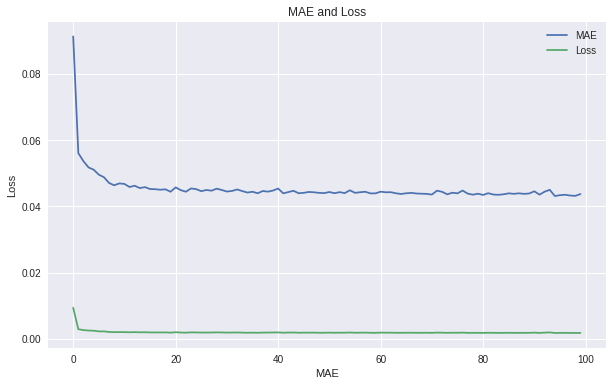

In [22]:
mae = history.history['mae']
loss = history.history['loss']
epochs=range(len(loss)) 

plot_series(x=epochs,
            y=(mae, loss), 
            title='MAE and Loss', 
            xlabel='MAE',
            ylabel='Loss',
            legend=['MAE', 'Loss'])

### Model Prediction

In [23]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

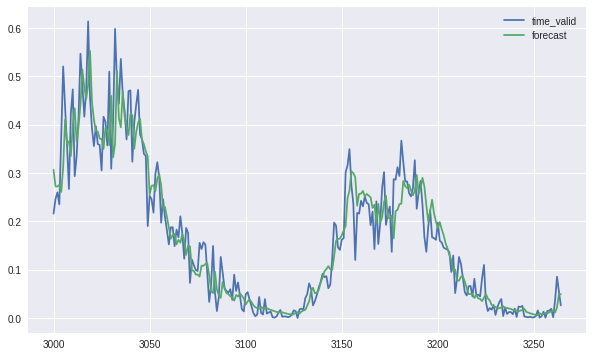

In [24]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axes
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results), legend=['time_valid', 'forecast'])

In [25]:
# Compute the MAE
print(f'MAE: {tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()}')

MAE: 0.033621035516262054


### Download Model

In [ ]:
from google.colab import files
files.download('model.h5')